# Should this loan be approved or not?

### Import Data & Library

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

%matplotlib inline

In [66]:
pd.set_option('display.max_columns', None)

In [67]:
SBA = pd.read_csv(r"C:\Users\ADMIN\Downloads\SBA_cleaned.csv", na_values='nan', index_col=None)
SBA.head()

,NAICS,Term,NoEmp,NewExist,RevLineCr,LowDoc,MIS_Status,SBA_GrPortion,RealEstate
0,44-45,84,4,2.0,N,Y,P I F,0.80,0
1,72,60,2,2.0,N,Y,P I F,0.80,0
2,62,180,7,1.0,N,N,P I F,0.75,0
3,31-33,120,19,1.0,N,N,P I F,0.75,0
4,81,84,1,2.0,N,Y,P I F,0.80,0


### Preprocessing

#### Handle outliers

"According to the SBA, a small businesses have a maximum of anywhere between 250 and 1500 employees— all depending on the specific industry the business is in. Additionally, businesses have revenue limits that they must not exceed if they want to qualify for SBA financing. In general, companies with more than 1500 employees are not eligible for SBA loans." 

References: https://www.sba7a.loans/sba-7a-loans-small-business-blog/small-business-definition

In [68]:
SBA[SBA['NoEmp'] > 1500].value_counts().sum() # 72, a very small portion of the data, so we can drop these rows
SBA = SBA[SBA['NoEmp'] < 1500]

#### Encode categorical variables

In [69]:
# Label encoding for the NewExist, RevLineCr, LowDoc, MIS_Status columns
label_encoder = LabelEncoder()

# Apply label encoding to the 'NewExist' column
SBA['NewExist'] = label_encoder.fit_transform(SBA['NewExist']) # 0: Existing business, 1: New business

# Apply label encoding to the 'RevLineCr' column
SBA['RevLineCr'] = label_encoder.fit_transform(SBA['RevLineCr']) # 0: N, 1: Y

# Apply label encoding to the 'LowDoc' column
SBA['LowDoc'] = label_encoder.fit_transform(SBA['LowDoc']) # 0: N, 1: Y

# Apply label encoding to the 'MIS_Status' column
SBA['MIS_Status'] = label_encoder.fit_transform(SBA['MIS_Status']) # 0: CHGOFF, 1: P I F

In [70]:
SBA.head()

,NAICS,Term,NoEmp,NewExist,RevLineCr,LowDoc,MIS_Status,SBA_GrPortion,RealEstate
0,44-45,84,4,1,0,1,1,0.80,0
1,72,60,2,1,0,1,1,0.80,0
2,62,180,7,0,0,0,1,0.75,0
3,31-33,120,19,0,0,0,1,0.75,0
4,81,84,1,1,0,1,1,0.80,0


#### Normalize `Term` and `NoEmp`

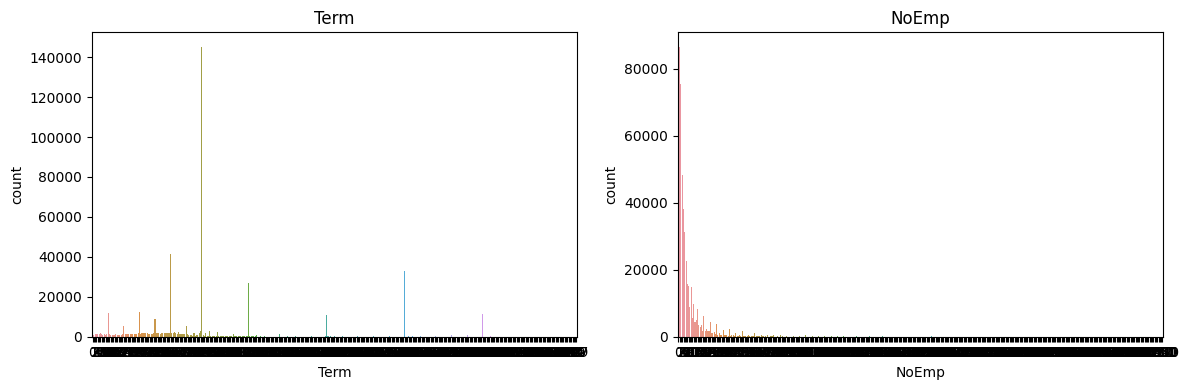

In [71]:
# Visualize the Term and NoEmp columns
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(data=SBA, x='Term')
plt.title('Term')

plt.subplot(1, 2, 2)
sns.countplot(data=SBA, x='NoEmp')
plt.title('NoEmp')

plt.tight_layout()
plt.show()

In [72]:
# minmax = MinMaxScaler()
# SBAnorm = pd.DataFrame(minmax.fit_transform(SBA[['Term', 'NoEmp']]), columns=['Term', 'NoEmp'])
# SBA.drop(['Term', 'NoEmp'], axis=1, inplace=True)
# SBA = pd.concat([SBA, SBAnorm], axis=1)

#### Handle `NAISC` column

In [73]:
SBA.head()

,NAICS,Term,NoEmp,NewExist,RevLineCr,LowDoc,MIS_Status,SBA_GrPortion,RealEstate
0,44-45,84,4,1,0,1,1,0.80,0
1,72,60,2,1,0,1,1,0.80,0
2,62,180,7,0,0,0,1,0.75,0
3,31-33,120,19,0,0,0,1,0.75,0
4,81,84,1,1,0,1,1,0.80,0


In [74]:
# NAICScol = pd.get_dummies(SBA['NAICS'], prefix='NAICS', drop_first=False)

In [75]:
# SBA = pd.concat([SBA, NAICScol], axis=1)
# SBA.drop('NAICS', axis=1, inplace=True)

In [76]:
SBA['MIS_Status'].unique()

array([1, 0])

In [77]:
SBA = SBA.replace({True: 1, False: 0})

In [78]:
SBA = SBA.dropna()

In [79]:
SBA.shape

(459432, 9)

In [80]:
SBA.head()

,NAICS,Term,NoEmp,NewExist,RevLineCr,LowDoc,MIS_Status,SBA_GrPortion,RealEstate
0,44-45,84,4,1,0,1,1,0.80,0
1,72,60,2,1,0,1,1,0.80,0
2,62,180,7,0,0,0,1,0.75,0
3,31-33,120,19,0,0,0,1,0.75,0
4,81,84,1,1,0,1,1,0.80,0


### Set Up Before Modelling

In [81]:
import category_encoders as ce
from sklearn.compose import make_column_transformer
features = ['NAICS', 'Term', 'NoEmp','RevLineCr' ,'NewExist','RealEstate','LowDoc','SBA_GrPortion']
# Prepare inputs 
X = SBA[features]
y = SBA['MIS_Status']
knn = KNeighborsClassifier(n_neighbors=13)

In [82]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=100)

### Modelling

#### KNN

#### Logistic Regression

#### Naive Bayes

#### Random Forest

In [83]:
from sklearn.pipeline import make_pipeline
binary_encoder = ce.BinaryEncoder()
ct = make_column_transformer((binary_encoder, ['NAICS']),
                             remainder='passthrough')
pipe = make_pipeline(ct, knn)
pipe.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['NAICS'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=13))])

In [84]:
%%time
cross_val_score(pipe, X_test, y_test, cv=10, scoring='accuracy', n_jobs=-1).mean()

CPU times: total: 156 ms
Wall time: 2.67 s


0.9176287333121028

In [85]:
grid_search_rfc.best_params_

NameError: name 'grid_search_rfc' is not defined

In [ ]:
rfc_grid = grid_search_rfc.best_estimator_

rfc_grid_pred = rfc_grid.predict(X_test)
rfc_grid_proba = rfc_grid.predict_proba(X_test)

In [ ]:
tnrfc, fprfc, fnrfc, tprfc = confusion_matrix(y_test, rfc_grid_pred).ravel()
print(confusion_matrix(y_test, rfc_grid_pred))